- Download data: https://drive.google.com/drive/folders/1hWGjgvzAQfrp8Sgm7zZCwQdzJOejojzN?usp=sharing
- Save them inside ./data

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Load data

- The raw mmWave data ADC has been processed and given you as a 3D numpy array of shape (NUM_CHIRPS, NUM_VIRTUAL_ANTENNAS, NUM_ADC_SAMPLES); also called the radar data cube (RDC)
- Data from a respiration belt
- Data from an EKG belt

- All data have been collected for 30 seconds

In [2]:
mm_data = np.load(r"data/mmWave_2.npy")
resp_data = np.load(r"data/resp_2.npy")
ekg_data = np.load(r"data/ekg_2.npy")

# print shapes
print("mmWave data shape: ", mm_data.shape)
print("Response data shape: ", resp_data.shape)
print("EKG data shape: ", ekg_data.shape)

mmWave data shape:  (60000, 8, 256)
Response data shape:  (600,)
EKG data shape:  (3650,)


In [3]:
# stretch the low resolution resp & EKG data to match the mmWave data (only for illustrative purposes)

# reshape resp data
zoom_factor_resp = (mm_data.shape[0] / resp_data.shape[0])
resp_data_reshaped = zoom(resp_data, zoom_factor_resp)

# reshape EKG data
zoom_factor_ekg = (mm_data.shape[0] / ekg_data.shape[0])
ekg_data_reshaped = zoom(ekg_data, zoom_factor_ekg)

# print shapes
print("mmWave data shape: ", mm_data.shape)
print("Response data shape: ", resp_data.shape)
print("EKG data shape: ", ekg_data.shape)

mmWave data shape:  (60000, 8, 256)
Response data shape:  (600,)
EKG data shape:  (3650,)


# Inspect ground truth resp sensor and EKG sensor data

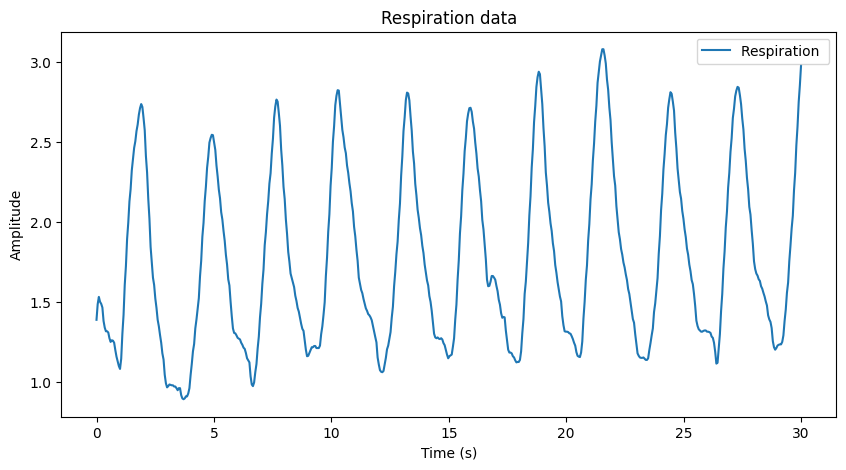

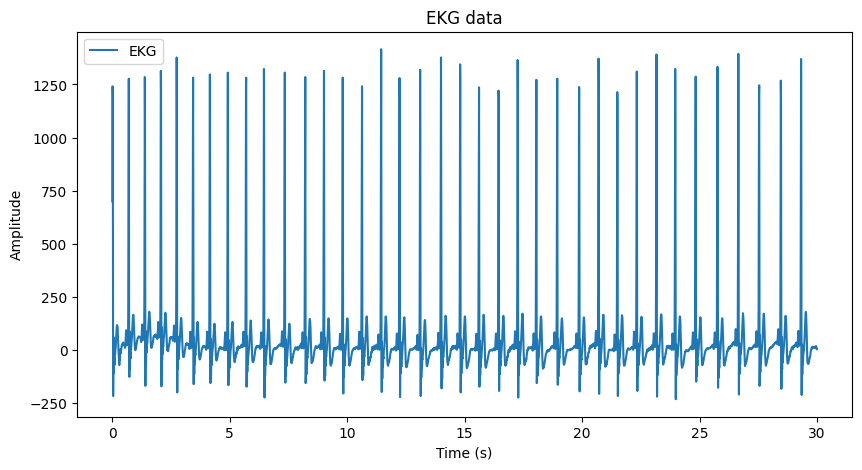

In [4]:
# time vector
t_start = 0
t_end = 30 # in seconds

# plot resp

t_resp = np.linspace(t_start, t_end, resp_data.shape[0])
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(t_resp, resp_data, label="Respiration ")
plt.title("Respiration data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# plot EKG
t_ekg = np.linspace(t_start, t_end, ekg_data.shape[0])
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(t_ekg, ekg_data, label="EKG")
plt.title("EKG data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## frequency domain

Resp sample rate:  20.0


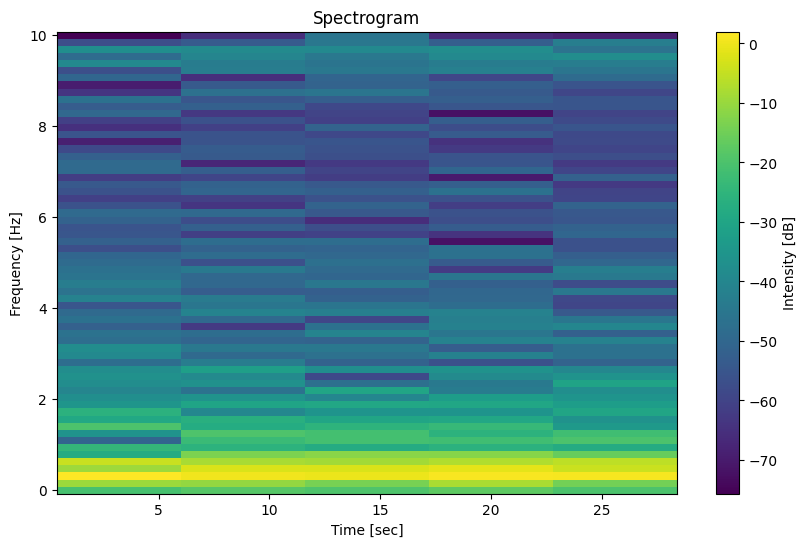

In [5]:
from scipy.signal import spectrogram

sample_rate_resp = resp_data.shape[0] / t_end
print("Resp sample rate: ", sample_rate_resp)

# Compute the spectrogram
frequencies, times, Sxx_resp = spectrogram(resp_data, sample_rate_resp, nperseg=128, nfft=128)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx_resp), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

EKG sample rate:  121.66666666666667


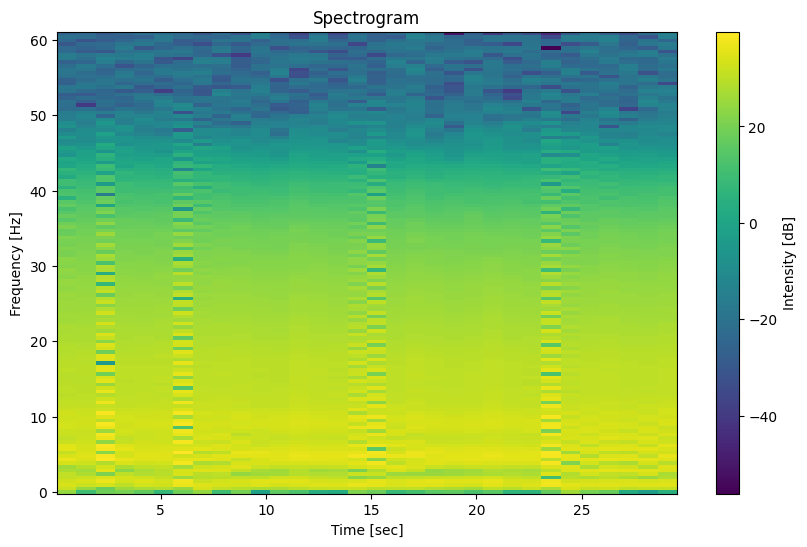

In [6]:
from scipy.signal import spectrogram

sample_rate_ekg = ekg_data.shape[0] / t_end
print("EKG sample rate: ", sample_rate_ekg)

# Compute the spectrogram
frequencies, times, Sxx_ekg = spectrogram(ekg_data, sample_rate_ekg, nperseg=128, nfft=256)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx_ekg), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()


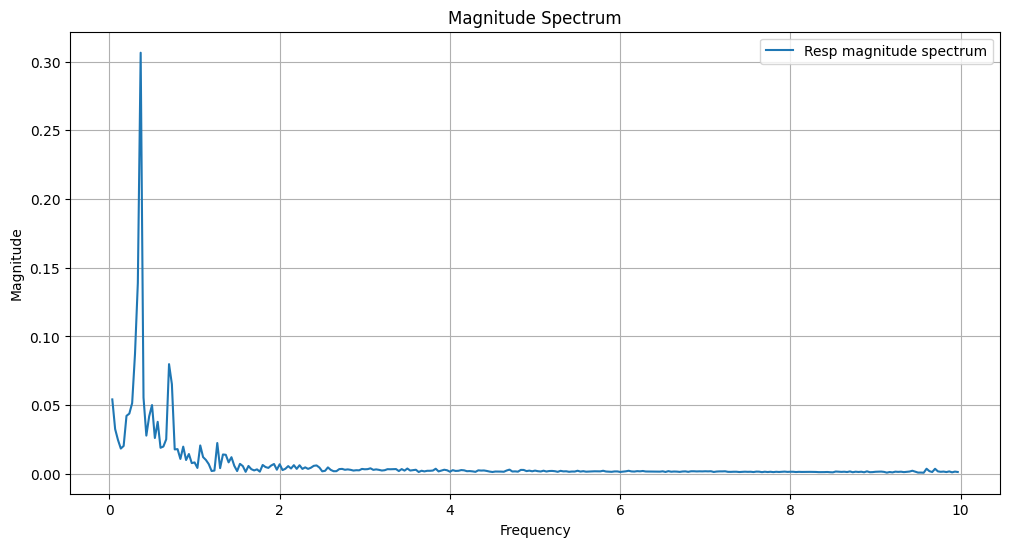

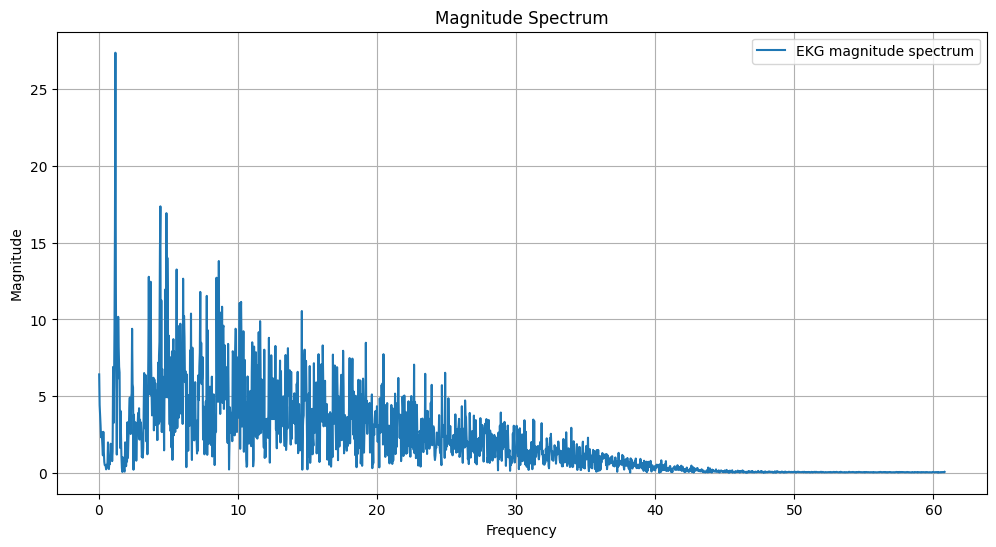

In [7]:
# resp data
fft_resp = np.fft.fft(resp_data, n=resp_data.shape[0])/resp_data.shape[0]
freq_resp = np.fft.fftfreq(resp_data.shape[0], d=1/sample_rate_resp)
positive_freq_resp = freq_resp[:resp_data.shape[0]//2]
fft_resp = fft_resp[:resp_data.shape[0]//2]

# Plot the magnitude spectrum
plt.figure(figsize=(12, 6))
plt.plot(positive_freq_resp[1:] , np.abs(fft_resp[1:]), label='Resp magnitude spectrum') # skip zero frequency bin (which is the DC component)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()
plt.show()

# ekg data
fft_ekg = np.fft.fft(ekg_data, n=ekg_data.shape[0])/ekg_data.shape[0]
freq_ekg = np.fft.fftfreq(ekg_data.shape[0], d=1/sample_rate_ekg)
positive_freq_ekg = freq_ekg[:ekg_data.shape[0]//2]
fft_ekg = fft_ekg[:ekg_data.shape[0]//2]

# Plot the magnitude spectrum
plt.figure(figsize=(12, 6))
plt.plot(positive_freq_ekg[1:] , np.abs(fft_ekg[1:]), label='EKG magnitude spectrum') # skip zero frequency bin (which is the DC component)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()
plt.show()

# Process RF data

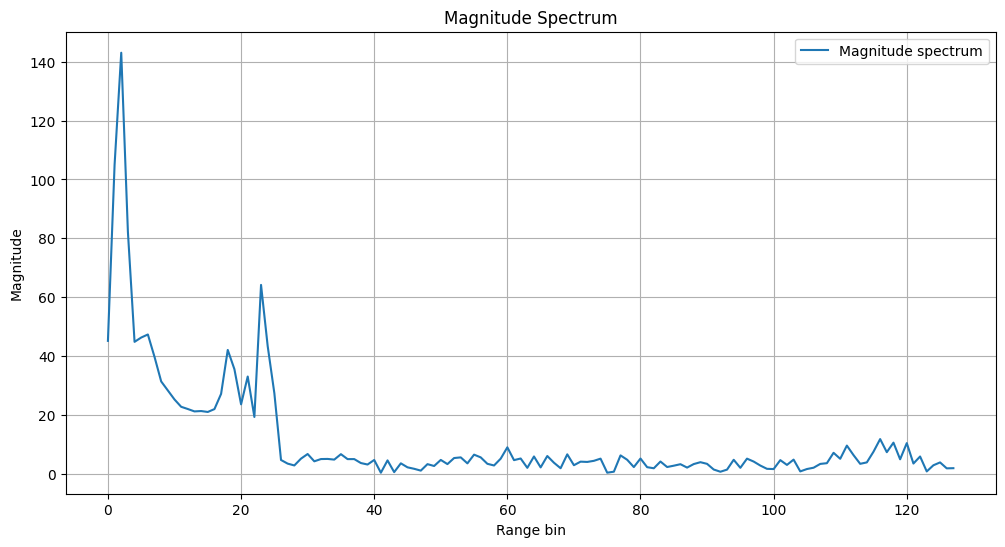

In [8]:
# select an antenna
Vx = 2 # we have 8 virtual antennas

# perform FFT on the RDC

range_fft = np.fft.fft(mm_data[:, Vx, :], n=mm_data.shape[-1], axis=-1)/mm_data.shape[-1] # shape: (num_frames, num_range_bins)

# analyze one frame
frame_idx = 10
frame = range_fft[frame_idx, :]

frame = frame[:frame.shape[0]//2] # keep only positive frequencies

# plot the magnitude spectrum
plt.figure(figsize=(12, 6))
plt.plot(np.abs(frame), label='Magnitude spectrum')
plt.title('Magnitude Spectrum')
plt.xlabel('Range bin')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()
plt.show()

In [9]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(np.abs(frame), height=50)
print("Peaks: ", peaks)

target_bins = peaks[1:] # skip the first peak which is the direct path from TX to RX
print("Target bins: ", target_bins)

Peaks:  [ 2 23]
Target bins:  [23]


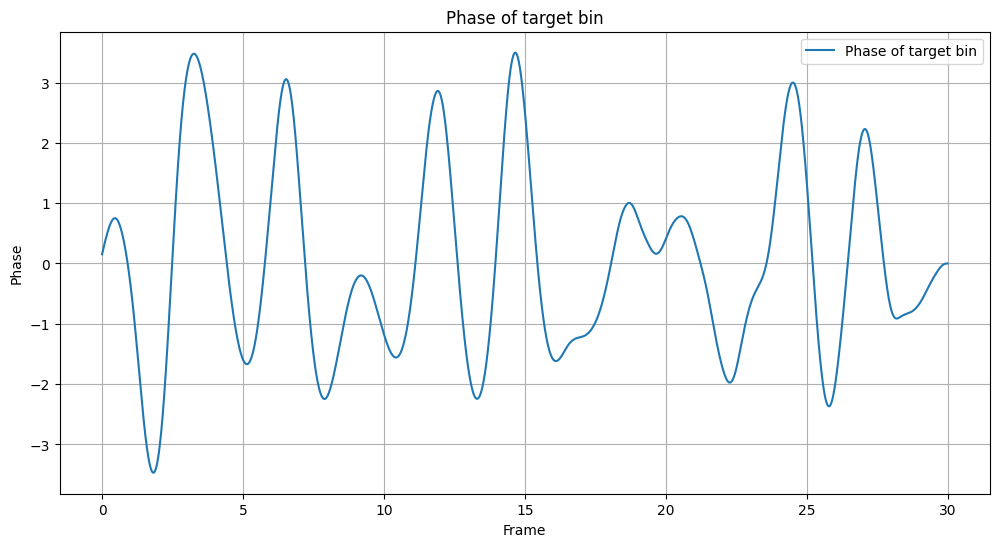

In [10]:
# filter the phase of the target bin across all chirps for breathing range (0.1 - 0.5 Hz)

from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal, b, a

# compute the sampling rate in this case (1 sample per frame)
t_phase = np.linspace(t_start, t_end, range_fft.shape[0])
sample_rate_phase = range_fft.shape[0] / t_end

# get the phase of the target bin and unwrap it (there might be some discontinuities, ignore them)
range_fft_phase = np.unwrap(np.angle(range_fft))

# filter the phase of the target bin
target_bins_phase = range_fft_phase[:, target_bins[0]]

b_lowcut = 0.1
b_highcut = 0.5

filtered_phase, b, a = bandpass_filter(target_bins_phase, b_lowcut, b_highcut, sample_rate_phase, order=2)


plt.figure(figsize=(12, 6))
plt.plot(t_phase, filtered_phase, label='Phase of target bin')
plt.title('Phase of target bin')
plt.xlabel('Frame')
plt.ylabel('Phase')
plt.grid()
plt.legend()
plt.show()

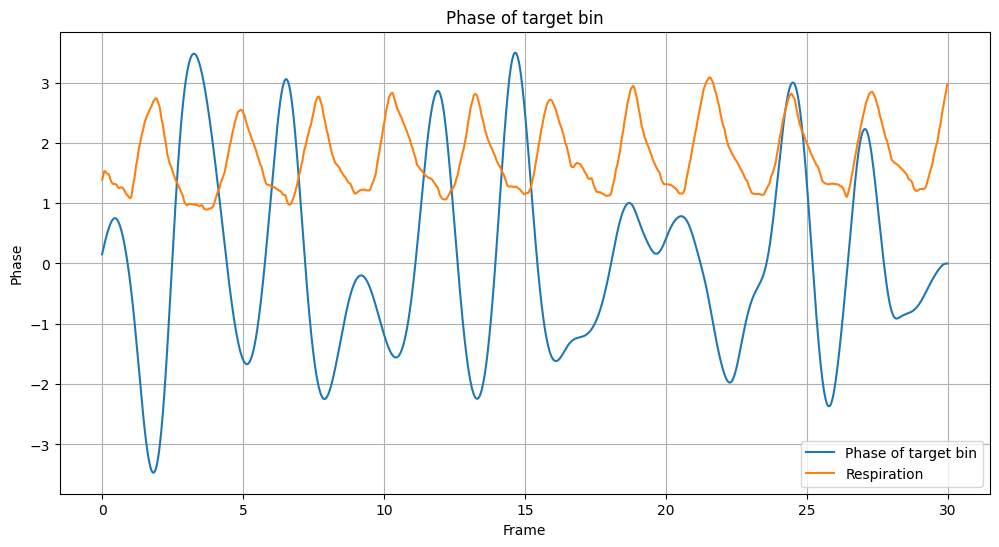

In [11]:
# compare with ground truth respiration signal

plt.figure(figsize=(12, 6))
plt.plot(t_phase, filtered_phase, label='Phase of target bin')
plt.plot(t_phase, resp_data_reshaped, label='Respiration')
plt.title('Phase of target bin')
plt.xlabel('Frame')
plt.ylabel('Phase')
plt.grid()
plt.legend()
plt.show()

In [12]:
# count peaks in the filtered phase signal

peaks_filtered_phase, _ = find_peaks(filtered_phase, height=0)
print("Num peaks in the filtered phase signal/Respiration rate (bpm): ", len(peaks_filtered_phase))

# compare with ground truth respiration signal
peaks_resp, _ = find_peaks(resp_data_reshaped, height=2)
print("Num peaks in the respiration signal/Respiration rate (bpm): ", len(peaks_resp))

Num peaks in the filtered phase signal/Respiration rate (bpm):  9
Num peaks in the respiration signal/Respiration rate (bpm):  10


-- THE END --